# Post processing and visualizing mandyoc data: Comparing initial an final thermal profiles

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import sys
import glob
import string
import numpy as np
import pylab as pl
import xarray as xr
import pandas as pd
import mpl_toolkits.axisartist
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)


path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/mandyoc-scripts/functions")
from mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, plot_property, _extract_interface, find_nearest

In [2]:
def calc_mean_temperaure_region(data, Nz, xx, begin, end):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nz: int
        Number of points in Z direction

    xx: numpy.ndarray
        2D grid with x cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    arr: `numpy.ndarray`
        Array containing the horizontal mean of selected region
    '''

    x_region = (xx >= begin) & (xx <= end)
    Nx_aux = len(x_region[0][x_region[0]==True])
    data_sel = data[x_region].reshape(Nz, Nx_aux)
    data_sel_mean = np.mean(data_sel, axis=1)
    
    return data_sel_mean


def calc_temper_profiles(data, Lx, Nz, xx, Lcraton=1200, onlycraton=False, shift=0.0):
    xcenter = (Lx/2)/1.0e3 + shift/1.0e3

    # keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - Lcraton/2, xcenter - Lcraton/6)
    # keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - Lcraton/12, xcenter + Lcraton/12)
    # keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + Lcraton/6, xcenter + Lcraton/2)

    keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - 350, xcenter - 250)
    keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - 50, xcenter + 50)
    keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 250, xcenter + 350)

    out_mean_l = calc_mean_temperaure_region(data, Nz, xx, 200, xcenter - Lcraton/2 - 200)
    out_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + Lcraton/2 + 200, Lx/1.03 - 200)

    if(onlycraton):
        temper_profiles = [keel_mean_l, keel_mean_c, keel_mean_r]
    else:
        temper_profiles = [out_mean_l, keel_mean_l, keel_mean_c, keel_mean_r, out_mean_r]

    return temper_profiles

def make_subplotA(ax, x, Lx, model_features, thickness_sa = 40 * 1.0e3, thickness_upper_crust = 20 * 1.0e3, thickness_lower_crust = 15 * 1.0e3, thickness_litho = 80 * 1.0e3):

    if(('mbdo' in model_features) or ('mbwo' in model_features)):
        mobile_belt = True
    else:
        mobile_belt = False

    if('sc' in model_features):
        shift_craton = 700.0e3
    else:
        shift_craton = 0.0e3

    if('lc' in model_features):
        Lcraton = 2000.0e3 #m
    else:
        Lcraton = 1200.0e3

    if('shallow30' in model_features):
        thinning = 135.0e3
    else:
        thinning = 100.0e3

    print(f"Mobile Belt: {mobile_belt}")
    print(f"Shift craton: {shift_craton}")
    print(f"Length of craton: {Lcraton/1.0e3} km")

    #Building the interfaces
    if(mobile_belt == False):
            interfaces = {
                    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa),
                    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
                    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
                    "air": np.ones(Nx) * (thickness_sa),
                    }

            dx = Lx/(Nx-1)
            thickening = thickness_litho + 120.e3 #m
            Ncraton = int(Lcraton//dx) #largura em indices
            
            Nshift = int(shift_craton//dx)
            interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

    else: #with mobile belt
        interfaces = {
            "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
            "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
            "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
            "air": np.ones(Nx) * (thickness_sa),
            }

        #Building craton
        dx = Lx/(Nx-1)
        # Lcraton = 600.0e3 #m
        # Lcraton = 1200.0e3 #m
    #     Lcraton = 2000.0e3 #m
        thickening = thickness_litho + 120.e3 #m

        Ncraton = int(Lcraton//dx) #largura em indices

        Nshift = int(shift_craton//dx)

        interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
        
        #Building mobile belt
        interfaces['litho_HETERO'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
        Lmb = 300.0e3 #length of mobile belt
        N_Lmb = int(Lmb//dx)
        # thinning = 50.0e3
        # thinning = 100.0e3
        # thickening = 135.0e3

        interfaces['litho_HETERO'][Nx//2 - N_Lmb//2 + Nshift : Nx//2 + N_Lmb//2 + Nshift] = thickness_sa + thickening - thinning

    alpha = 1
    color='xkcd:black'
    if(mobile_belt):
        ax.plot(x, interfaces['litho_LAB']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='litho interface')
        ax.plot(x, interfaces['litho_HETERO']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='litho interface')
        ax.plot(x, interfaces['lower_crust']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='lower crust interface')
        ax.plot(x, interfaces['upper_crust']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='upper crust interface')
        ax.plot(x, interfaces['air']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='air interface')
    else:
        ax.plot(x, interfaces['litho_LAB']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='litho interface')
        ax.plot(x, interfaces['lower_crust']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='lower crust interface')
        ax.plot(x, interfaces['upper_crust']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='upper crust interface')
        ax.plot(x, interfaces['air']/1000-40, color=color, linestyle='-', linewidth=1.0, alpha=alpha, zorder=30, label='air interface')

    #layers colour scheme
    cr = 255.
    color_uc = (228./cr,156./cr,124./cr)
    color_lc = (240./cr,209./cr,188./cr)
    color_lit = (155./cr,194./cr,155./cr)
    color_mb = 'xkcd:dull green'
    # color_mb = color_lit
    color_ast = (207./cr,226./cr,205./cr)

    #paint layers
    # mobile_belt=False
    if(mobile_belt):
        #paint layers
        a1_stab = interfaces["litho_LAB"] - 40.0e3
        a2_stab = a1_stab*0 + 700.0E3 - 40.0e3
        
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_ast,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab = interfaces["litho_HETERO"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_mb,ec="face",lw=0.0, alpha=0.6)

        a2_stab = np.copy(a1_stab)
        a1_stab = interfaces["lower_crust"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_lit,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab = interfaces["upper_crust"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_lc,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab= interfaces["air"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_uc,ec="face",lw=0.0)

    else:
        a1_stab = interfaces["litho_LAB"]-40.0e3
        a2_stab = a1_stab*0+700.0E3-40.0e3

        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_ast,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab = interfaces["lower_crust"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_lit,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab = interfaces["upper_crust"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_lc,ec="face",lw=0.0)

        a2_stab = np.copy(a1_stab)
        a1_stab= interfaces["air"]-40.0e3
        ax.fill_between(x, a1_stab/1000, a2_stab/1000,fc=color_uc,ec="face",lw=0.0)

    xcenter = (Lx/2)/1.0e3
    condl = (x >= (xcenter - 350)) & (x <= (xcenter - 250))
    condc = (x >= (xcenter - 50)) & (x <= (xcenter + 50))
    condr = (x >= (xcenter + 250)) & (x <= (xcenter + 350))

    cond_outl = (x >= 200) & (x <= (xcenter - Lcraton/2.0e3 - 200))
    cond_outr = (x >= (xcenter + Lcraton/2.e3 + 200)) & (x <= (Lx/1.0e3 - 200))

    # color='black'
    # color='grey'
    color='xkcd:purple'
    # color='xkcd:light grey'
    ax.fill_between(x[cond_outl], 660, 0, fc=color, ec="face", lw=0.0, alpha=0.3)
    ax.fill_between(x[condl], 660, 0, fc=color, ec="face", lw=0.0, alpha=0.3)
    ax.fill_between(x[condc], 660, 0, fc=color, ec="face", lw=0.0, alpha=0.3)
    ax.fill_between(x[condr], 660, 0, fc=color, ec="face", lw=0.0, alpha=0.3)
    ax.fill_between(x[cond_outr], 660, 0, fc=color, ec="face", lw=0.0, alpha=0.3)
    
    ax.set_xlim([xcenter-Lcraton/2.0e3-50, xcenter+Lcraton/2.0e3+50])
    ax.set_ylim([660, -40])
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.xaxis.set_label_position('top')

    ax.set_xlabel('Distance [km]')
    ax.set_ylabel('Depth [km]')

    

In [3]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"

scenarios = [
             f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf",
             f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb5",
             f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb3",
             f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb1",
             ]

print(f"Scernarios:")
for scenario in scenarios:
    print(f"{scenario.split('/')[-1]}")

#Read datasets
    
dataset0 = xr.open_dataset(f'{scenarios[0]}/_output_temperature.nc')
dataset1 = xr.open_dataset(f'{scenarios[1]}/_output_temperature.nc')
dataset2 = xr.open_dataset(f'{scenarios[2]}/_output_temperature.nc')
dataset3 = xr.open_dataset(f'{scenarios[3]}/_output_temperature.nc')

Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(dataset0.info)

Scernarios:
keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf
keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb5
keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb3
keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb1
<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (time: 401, x: 401, z: 71)
Coordinates:
  * time         (time) float64 0.0 2.5 5.0 7.5 10.0 ... 992.5 995.0 997.5 1e+03
    step         (time) int32 ...
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 3.98e+06 3.99e+06 4e+06
  * z            (z) float64 -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    temperature  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                401
    nz:                                71
    lx:                                4000000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
   

# Plot Article

Mobile Belt: True
Shift craton: 0.0
Length of craton: 1200.0 km


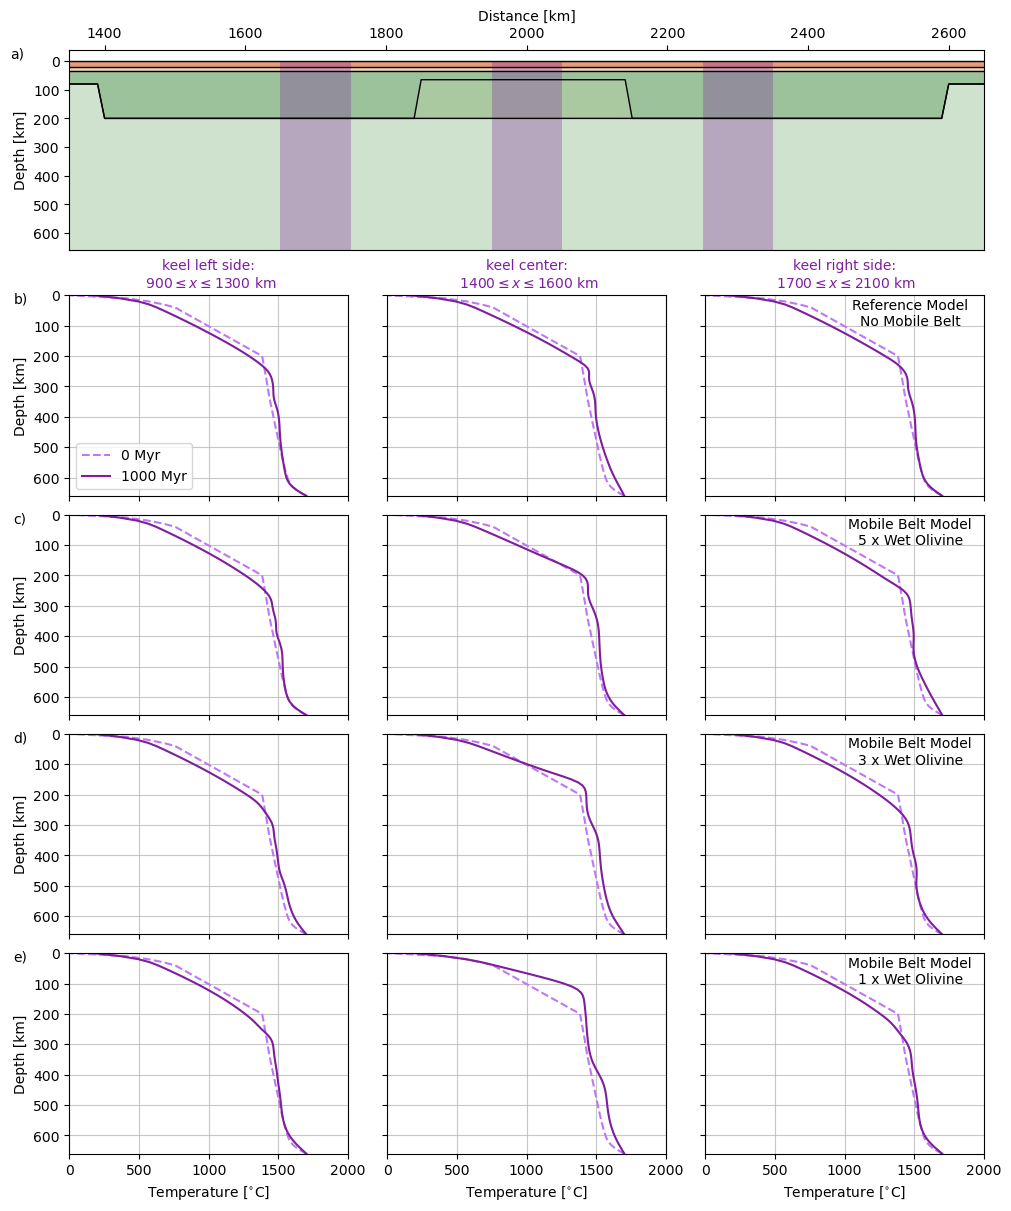

In [13]:
plt.close('all')

fig = plt.figure(figsize=(10,12), constrained_layout=True)
mosaic = """
         AAA
         BCD
         EFG
         HIJ
         KLM
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.5,
                                                               0.5,
                                                               0.5,
                                                               0.5,
                                                               0.5
                                                              ]
                                             }
                        )

alphabet = list(string.ascii_uppercase)
idxs_yse = np.asarray(alphabet[1: 3*len(scenarios)+1]) #starting at B subplot
idxs_yse_aux = idxs_yse.reshape(len(scenarios), 3)
#Subplot A
model_features = scenarios[1].split('/')[-1].split('_')
make_subplotA(axs['A'], x, Lx, model_features)

#Dealing with the other subplots
onlycraton = True
if(onlycraton):
    Hlits = [200.0e3, 200.0e3, 200.0e3]
else:
    Hlits = [80.0e3, 200.0e3, 200.0e3, 200.0e3, 80.0e3]

thickness_sa = 40.0e3
z_aux = z - thickness_sa/1.0e3
cond_aux = z_aux >= 0

# axs[idxs_yse[0][0]].plot(range(1, 5), range(1, 5), color='black')
col_linestyle = ['--', '-']
col_color = ['xkcd:light purple', 'xkcd:purple']

instants = [0, 1000]
for instant, i in zip(instants, range(len(instants))):
    idx = find_nearest(dataset0.time, instant)

    datas = [dataset0.temperature[idx].values.T,
            dataset1.temperature[idx].values.T,
            dataset2.temperature[idx].values.T,
            dataset3.temperature[idx].values.T,
            ]
    
    temper_profiles_list = []
    for line, data in zip(range(len(datas)), datas):
        temperature_profiles = calc_temper_profiles(data, Lx, Nz, xx, onlycraton=onlycraton)
        
        for col, temper_profile, thickness_litho in zip(range(len(temperature_profiles)), temperature_profiles, Hlits): 
            axs[idxs_yse_aux[line][col]].plot(temper_profile[cond_aux], z_aux[cond_aux], color=col_color[i], linestyle=col_linestyle[i], label=f'{instant} Myr')

############################################################################################################################################################################

xpos = 0.735
ypos = 0.91
fsize = 10
axs['D'].text(xpos, ypos, f"Reference Model\nNo Mobile Belt", color='k', fontsize=fsize,
        horizontalalignment='center', verticalalignment='center',
        transform=axs['D'].transAxes)

axs['G'].text(xpos, ypos,  f"Mobile Belt Model\n5 x Wet Olivine", color='k', fontsize=fsize,
        horizontalalignment='center', verticalalignment='center',
        transform=axs['G'].transAxes)

axs['J'].text(xpos, ypos,  f"Mobile Belt Model\n3 x Wet Olivine", color='k', fontsize=fsize,
        horizontalalignment='center', verticalalignment='center',
        transform=axs['J'].transAxes)

axs['M'].text(xpos, ypos,  f"Mobile Belt Model\n1 x Wet Olivine", color='k', fontsize=fsize,
        horizontalalignment='center', verticalalignment='center',
        transform=axs['M'].transAxes)

#Setting the limits and axis labels
for idx_yse in idxs_yse:
    axs[idx_yse].set_xlim([0, 2000])
    axs[idx_yse].set_ylim([660, 0])
    axs[idx_yse].grid('k', alpha=0.7)
    if(idx_yse == 'B' or idx_yse == 'E' or idx_yse == 'H' or idx_yse == 'K'):
        axs[idx_yse].set_ylabel('Depth [km]')
    else:
        axs[idx_yse].set_yticklabels([])

    if(idx_yse == 'K' or idx_yse == 'L' or idx_yse == 'M'):
        axs[idx_yse].set_xlabel(r'Temperature [$^{\circ}$C]')
    else:
        axs[idx_yse].set_xticklabels([])

locations = [
             f'keel left side:\n $900 \leq x \leq 1300$ km',
             f'keel center:\n $1400 \leq x \leq 1600$ km',
             f'keel right side:\n $1700 \leq x \leq 2100$ km',
            ]

for letter, location in zip(idxs_yse_aux[0], locations):
    axs[letter].set_title(location, fontsize=fsize, color='xkcd:purple')

xpos = 0.1
ypos = 0.15
axs['B'].legend(loc='lower left', fontsize=fsize)
# axs['D'].text(xpos, ypos,  "-- 0 Myr", color='xkcd:purple', fontsize=fsize,
#         horizontalalignment='left', verticalalignment='center',
#         transform=axs['D'].transAxes)
# axs['D'].text(xpos, ypos-0.1,  " - 1000 Myr", color='xkcd:purple', fontsize=fsize,
#         horizontalalignment='left', verticalalignment='center',
#         transform=axs['D'].transAxes)
xpos = -0.2
ypos = 0.98
subplots_idxs = ['A', 'B', 'E', 'H', 'K']
subplots_labels = ['a)', 'b)', 'c)', 'd)', 'e)']

for subplot_idx, subplot_label in zip(subplots_idxs, subplots_labels):
    if(subplot_idx == 'A'):
        axs[subplot_idx].text(-0.065, ypos, subplot_label, color='xkcd:black', fontsize=fsize,
            horizontalalignment='left', verticalalignment='center',
            transform=axs[subplot_idx].transAxes)
    else:
        axs[subplot_idx].text(xpos, ypos, subplot_label, color='xkcd:black', fontsize=fsize,
            horizontalalignment='left', verticalalignment='center',
            transform=axs[subplot_idx].transAxes)

figname = f"Temper_profiles_REF_vs_MBWO"
fig.savefig(f"figures/{figname}.png", dpi=300, bbox_inches='tight')
fig.savefig(f"figures/{figname}.pdf", dpi=300, bbox_inches='tight')